In [1]:
# MISC
import os
import sys
%load_ext autoreload 

sys.path.append("..")
os.environ['MUJOCO_GL']='egl'
os.environ['CUDA_VISIBLE_DEVICES']='1'

import shutup
shutup.please()

import jax
from jax import random
import jax.numpy as jnp
import numpy as np
import functools

# RL 
import gymnasium
import flashbax as fbx

# VIS
import matplotlib.pyplot as plt
import mediapy
import scienceplots
from rich.pretty import pprint
from tqdm.auto import tqdm

plt.style.use(['science', 'notebook'])

GLOBAL_KEY = jax.random.key(42)

<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead


In [110]:
from envs.custom_mazes import BaseMaze, BaseEnv, Object, DeepMindColor as color
from envs.custom_mazes.generators.four_room import generate_four_room_env
from envs.custom_mazes.motion import VonNeumannMotion
from gymnasium.spaces import Discrete, Dict, Box

maze_grid = generate_four_room_env(11, 11)
pprint(maze_grid)

class Maze(BaseMaze):
    def __init__(self, maze_grid, **kwargs):
        self.maze_grid = maze_grid
        super().__init__(**kwargs)
        
    @property
    def size(self):
        return self.maze_grid.shape
    
    def make_objects(self):
        free = Object('free', 0, color.free, False, np.stack(np.where(self.maze_grid == 0), axis=1))
        obstacle = Object('obstacle', 1, color.obstacle, True, np.stack(np.where(self.maze_grid == 1), axis=1))
        agent = Object('agent', 2, color.agent, False, [])
        goal = Object('goal', 3, color.goal, False, [])
        return free, obstacle, agent, goal

class FourRoomsMazeEnv(BaseEnv):
    def __init__(self, maze, max_width=100):
        super().__init__(max_width)
        
        self.maze = maze
        self.motions = VonNeumannMotion()
        self.action_space = Discrete(len(self.motions))
        self.observation_space = Box(low=0, high=self.maze.size[0], shape=(2, ), dtype=np.uint8)
        self.goal = None
        self.start = None
        self.maze_state = self.maze.maze_grid
        
    def reset(self, seed=None, options={}):
        super().reset(seed, options)
        start_idx = options.get('start', None)
        goal_idx = options.get('goal', None)

        if start_idx is None:
            start_idx = self.generate_pos()
        if goal_idx is None:
            goal_idx = self.generate_goal()
            
        self.maze.objects.agent.positions = [start_idx]
        self.maze.objects.goal.positions = [goal_idx]
        self.goal = goal_idx
        self.start = start_idx
        self.maze_state = self.maze.to_value()
        return start_idx, {"goal_pos": goal_idx}
    
    def generate_pos(self):
        return self.np_random.choice(self.maze.objects.free.positions)
    
    def generate_goal(self):
        return self.np_random.choice(self.maze.objects.free.positions)
    
    def _is_valid(self, position):
        nonnegative = position[0] >= 0 and position[1] >= 0
        within_edge = position[0] < self.maze.size[0] and position[1] < self.maze.size[1]
        passable = not self.maze.to_impassable()[position[0]][position[1]]
        return nonnegative and within_edge and passable
    
    def _is_goal(self, position):
        for goal_pos in self.maze.objects.goal.positions:
            if np.array_equal(goal_pos, position):
                return True
        return False
    
    def step(self, action):
        motion = self.motions[action]
        current_position = self.maze.objects.agent.positions[0]
        new_position = [current_position[0] + motion[0], current_position[1] + motion[1]]
        valid = self._is_valid(new_position)
        reward = 0.0
        done=False
        if valid:
            self.maze.objects.agent.positions = [new_position]
        if self._is_goal(new_position):
            reward = 1.0
            done = True
        else:
            new_position = current_position
        self.maze_state = self.maze.to_value()
        return new_position, reward, done, False, {}
        
    def get_image(self):
        return self.maze.to_rgb()

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
│      [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
│      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
│      [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
│      [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
│      [1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
│      [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
│      [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
│      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
│      [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
│      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

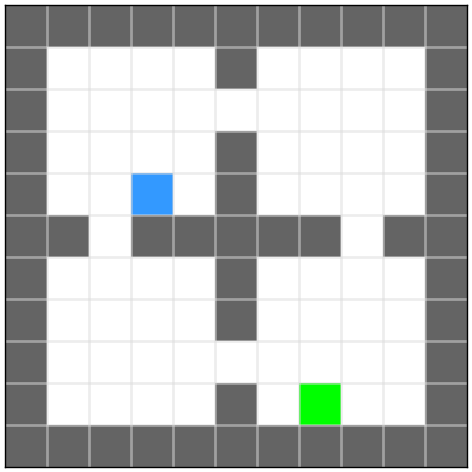

In [111]:
test = FourRoomsMazeEnv(Maze(maze_grid=maze_grid))
test.reset()
img = test.render() 

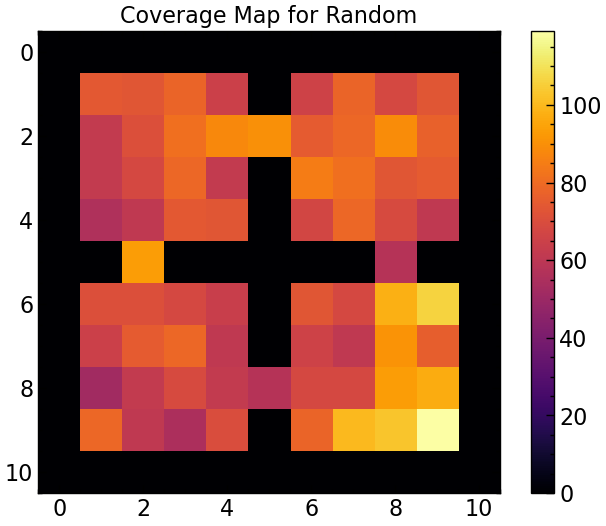

  0%|          | 0/50 [00:00<?, ?it/s]

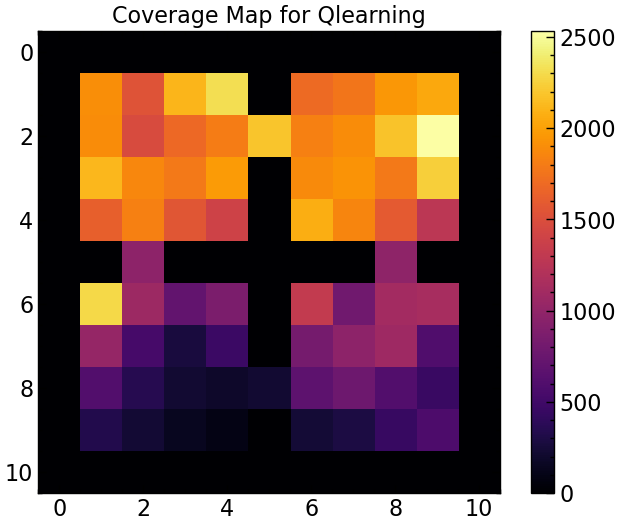

In [ ]:
def random_exploration(env, num_episodes=50, num_steps=100):
    coverage_map = np.where(env.maze_state == 1, -100, 0)
    for _ in range(num_episodes):
        i=0
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        while i < num_steps:
            i+=1
            action = env.action_space.sample()
            next_state, reward, done, _, _ = env.step(action)
            coverage_map[next_state[0], next_state[1]] += 1
    return coverage_map

def q_learning(env, num_episodes=50, alpha=0.1, gamma=0.99, epsilon=0.3):
    Q = np.zeros((env.maze.size[0], env.maze.size[1], env.action_space.n))
    coverage_map = np.where(env.maze_state == 1, -1000, env.maze_state)
    
    for _ in tqdm(range(num_episodes), colour='green', leave=False):
        state, info = env.reset()
        coverage_map[state[0], state[1]] += 1
        done = False
        step = 0
        while not done:
            if (np.random.rand() < epsilon) and step < 50:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state[0], state[1], :])
            
            next_state, reward, done, _, _ = env.step(action)
            
            Q[state[0], state[1], action] += alpha * (reward + gamma * np.max(Q[next_state[0], next_state[1], :]) - Q[state[0], state[1], action])
            
            coverage_map[next_state[0], next_state[1]] += 1
            state = next_state
            
    return coverage_map

def visualize_coverage_map(coverage_map, name):
    plt.imshow(coverage_map, cmap='inferno', vmin=0)
    plt.colorbar()
    plt.title(f'Coverage Map for {name}')
    plt.show()

# Example usage
env = FourRoomsMazeEnv(Maze(maze_grid))
coverage_map_random = random_exploration(env)
visualize_coverage_map(coverage_map_random, name='Random')

coverage_map_q_learning = q_learning(env)
visualize_coverage_map(coverage_map_q_learning, name='Qlearning')